In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, GRU, Dense
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import re, io, os, time
import unicodedata

## Preprocess Dataset

In [ ]:
dataset_path_zip = tf.keras.utils.get_file( fname='spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip', cache_dir='/content/', extract=True)
dataset_path = os.path.dirname(dataset_path_zip) + "/spa-eng/spa.txt"

2646016/2638744 [==============================] - 0s 0us/step


In [ ]:
def convert_unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c) != 'Mn' )
    #Mn	Nonspacing_Mark	a nonspacing combining mark (zero advance width)

In [ ]:
#Unit testing
convert_unicode_to_ascii('Hello hi')

'Hello hi'

In [ ]:
def preprocess_sentence(s):
    s = convert_unicode_to_ascii(s.lower().strip()) #strip removes initial or trailing spaces

    #Give space between a word/alphabet and a punctuation
    # Eg: Example sentence to demonstrate spacing. -> Example sentence to demonstrate spacing .
    s = re.sub(r"([.,!?¿])", r" \1 ",s)

    #Now remove the extra spaces which maybe caused by the first regex
    s = re.sub(r'[" "]+'," ",s)

    #Replace all unacceptable characters with space
    s = re.sub(r"[^a-zA-Z.,!?¿]+"," ",s)

    #Remove initial and trailing spaces
    s = s.strip()

    #Add a start and end token
    s = '<start> ' + s + ' <end>'



    return s

In [ ]:
#Unit Testing
english_sentence = u"What is your name?!"
spanish_sentence = u"¡¿Cuál es tu nombre?!"
print(preprocess_sentence(english_sentence))
print(preprocess_sentence(spanish_sentence))

<start> what is your name ? ! <end>
<start> ¿ cual es tu nombre ? ! <end>


In [ ]:
def load_dataset(dataset_path, num_sentences):
    lines = io.open(dataset_path,encoding='UTF-8').read().strip().split('\n')

    #The english and spanish sentences are seperated by a tab (\t) in the dataset file
    sentences_pairs = [[preprocess_sentence(s) for s in l.split('\t')] for l in lines[:num_sentences]]
    
    #Unzip the pairs
    en_sentences, spanish_sentences = zip(*sentences_pairs)
    return en_sentences, spanish_sentences

In [ ]:
en,sp = load_dataset(dataset_path,None)

In [ ]:
def tokenize(lang_sentences):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters = '' #Remove the default filters available in the function
    )

    tokenizer.fit_on_texts(lang_sentences)
    seq = tokenizer.texts_to_sequences(lang_sentences)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(sequences=seq,padding='post')

    return tensor, tokenizer

In [ ]:
def create_dataset(dataset_path,num_sentences=None):

    # Input - Spanish , Target - English
    target_lang, input_lang = load_dataset(dataset_path,num_sentences)

    input_tensor, input_tokenizer = tokenize(input_lang)
    target_tensor, target_tokenizer = tokenize(target_lang)

    return input_tensor, input_tokenizer, target_tensor, target_tokenizer



In [ ]:
input_tensor, input_lang, target_tensor, target_lang = create_dataset(dataset_path)
print(f'No. of unique tokens in input language (Spanish) : {len(input_lang.word_index)}')
print(f'No. of unique tokens in target language (English) : {len(target_lang.word_index)}')

No. of unique tokens in input language (Spanish) : 24793
No. of unique tokens in target language (English) : 12933


In [ ]:
input_max_len, target_max_length = input_tensor.shape[1], target_tensor.shape[1]

In [ ]:
#Split the dataset into train and val split
train_input, val_input, train_target, val_target = train_test_split(input_tensor,target_tensor,test_size=0.2,random_state=41)

print(f'No. of spanish and english sentences in the training set are {len(train_input)} and {len(train_target)}')
print(f'No. of spanish and english sentences in the validation set are {len(val_input)} and {len(val_target)}')

No. of spanish and english sentences in the training set are 95171 and 95171
No. of spanish and english sentences in the validation set are 23793 and 23793


In [ ]:
def index_to_sentences(lang,s):
    for i in s:
        if i!=0: #Ignoring pad (0) token
            print(f'{i} ---> {lang.index_word[i]}')

In [ ]:
print("Input Language Mapping sample")
print(index_to_sentences(input_lang,train_input[0]))
print("Target Language Mapping sample")
print(index_to_sentences(target_lang,train_target[0]))

Input Language Mapping sample
1 ---> <start>
28 ---> ella
690 ---> vendra
19 ---> esta
135 ---> noche
3 ---> .
2 ---> <end>
None
Target Language Mapping sample
1 ---> <start>
27 ---> she
52 ---> will
37 ---> be
62 ---> here
23 ---> this
726 ---> evening
3 ---> .
2 ---> <end>
None


In [ ]:
BUFFER_SIZE = len(train_input)
BATCH_SIZE = 128
EMBEDDING_DIM = 300
ENC_GRU_UNITS = DEC_GRU_UNITS = 1024

In [ ]:
#Create tf.data dataset for efficient loading and processing
steps_per_epoch = BUFFER_SIZE // BATCH_SIZE
input_vocab_size = len(input_lang.word_index) + 1 # +1 to include the last index word in the size count
target_vocab_size = len(target_lang.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices((train_input,train_target)).shuffle(BUFFER_SIZE)

#Create batches
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
test_input, test_target = next(iter(dataset))
test_input.shape, test_target.shape

(TensorShape([128, 53]), TensorShape([128, 51]))

In [ ]:
#Refer the shapes of GRU Outputs
inputs = tf.random.normal([32, 10, 8]) #(Batch-size,vocab_size,embedding_dim)
gru = tf.keras.layers.GRU(4) 
output = gru(inputs) 
print(output.shape) #(32, 4) 
gru = tf.keras.layers.GRU(4, return_sequences=True, return_state=True)  
#final_state = gru(inputs) 
whole_sequence_output, final_state = gru(inputs) 
print(whole_sequence_output.shape) #(32, 10, 4) 
print(final_state.shape) #(32, 4)
#The Last hidden state is equal to the final state
#whole_sequence_output[:,-1,:] == final_state()

(32, 4)
(32, 10, 4)
(32, 4)


## Create Custom Model

The Attention mechanism is applied to a RNN Encoder-Decoder network in the following way : 

![Attention Mechanism](Images/LuongAttentionMechanism.jpg)


<br>

where,
  - Blue box denotes the Encoder hidden states (Encoder output)
  - Red box denotes the decoder hidden states


` The code for BahdanauAttention Model is clearly annotated for more clarity.`



### Encoder

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self,batch_sz,vocab_size,embedding_dim,enc_units):
        super(Encoder,self).__init__()
        self.batch_size = batch_sz
        self.gru_units = enc_units

        self.embedding = Embedding(vocab_size,embedding_dim)
        self.gru = GRU(self.gru_units,
                       return_sequences=True,
                       return_state=True,
                       recurrent_initializer='glorot_uniform')
        
    def call(self,x,hidden):
        x = self.embedding(x)
        sequence_output,state = self.gru(x,initial_state = hidden)

        return sequence_output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size,self.gru_units))

In [ ]:
encoder = Encoder(BATCH_SIZE,input_vocab_size,EMBEDDING_DIM,ENC_GRU_UNITS)
test_hidden = encoder.initialize_hidden_state()
test_enc_output, test_hidden = encoder(test_input,test_hidden)
print(f'Encoder output sequence shape of the form (BATCH_SIZE, SEQUENCE_LENGTH, GRU_UNITS) is {test_enc_output.shape}')
print(f'Encoder hidden state shape of the form (BATCH_SIZE,GRU_UNITS) is {test_hidden.shape}')

Encoder output sequence shape of the form (BATCH_SIZE, SEQUENCE_LENGTH, GRU_UNITS) is (128, 53, 1024)
Encoder hidden state shape of the form (BATCH_SIZE,GRU_UNITS) is (128, 1024)



Bahdanau Attention consists of the following main steps:



- `Attention score = V(tanh(W1(Encoder_Outputs) + W2(Decoder_Hidden_State)))`
* `Attention weights = softmax(Attention_Score, axis = 1)`
* `Context Vector = sum(attention_weights * Encoder_Outputs, axis = 1)`
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `Modified vector = concat(Decoder_Hidden_State, Context Vector)`
* This Modified vector is then given to the GRU

<br>

The following equations are from Bahdanau Attention paper:

![BahdanauAttention Equation 1](Images/BahdanauAttention_Equation_1.jpg)
![BahdanauAttention Equation 2](Images/BahdanauAttention_Equation_1.jpg)



### BahdanauAttention

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self,units):
        super(BahdanauAttention,self).__init__()
        #units should be equal to decoder_gru_units, encoder_gru_units
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)


    def call(self,query,values):
        #query is the hidden state of the decoder => (BATCH_SIZE,GRU_DEC_UNITS)
        #Values is the output seq of the encoder -> Shape=(BATCH_SIZE, SEQUENCE_LENGTH, GRU_ENC_UNITS)

        #SEQUENCE_LENGTH corresponds to the number of hidden states in the encoder
        #GRU_DEC_UNITS = GRU_ENC_UNITS


        ###Step 1: Expand the dim of the query(dec_hidden_state) along axis 1 to denote we are querying for a single decoder hidden state
        
        #Expand the dim of thq query along the time axis
        query_time_axis = tf.expand_dims(query,axis=1) #Shape -> (BATCH_SIZE,1,GRU_DEC_UNITS)


        ###Step 2: Compute the attention scores for each encoder hidden states(SEQUENCE_LENGTH)
        
        #Attention score for each hidden layer. score shape -> (BATCH_SIZE, SEQUENCE_LENGTH,1)
        score = self.V(tf.nn.tanh(
            self.W1(query_time_axis) + self.W2(values)))
        
        attention_weights = tf.nn.softmax(score,axis=1) #Attention_weights shape -> (BATCH_SIZE, SEQUENCE_LENGTH,1)


        ###Step 3: Apply the attention weights to the respective hidden states and compute the context vector

        #weighted_enc_hidden_states is in shape as values because we are just multiplying some weights to each value
        weighted_enc_hidden_states = attention_weights * values #shape -> (BATCH_SIZE, SEQUENCE_LENGTH,GRU_ENC_UNITS)


        ###Step 4: Add all the weighted hidden states to form the context vector

        #Form a single context_vector by adding all weighted_enc_hidden_states of each enc hidden state
        context_vector = tf.reduce_sum(weighted_enc_hidden_states, axis=1) #shape-> (BATCH_SIZE,GRU_ENC_UNITS) 


        return context_vector, attention_weights


In [ ]:
test_attention = BahdanauAttention(10)
attention_result, attention_weights = test_attention(test_hidden,test_enc_output)
print(f'Attention result (context vector) shape : {attention_result.shape}')
print(f'Attention weights (score for each enc hidden state) shape : {attention_weights.shape}') #Can be viewed as attention for each words

Attention result (context vector) shape : (128, 1024)
Attention weights (score for each enc hidden state) shape : (128, 53, 1)


### Decoder

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,batch_sz,vocab_size,embedding_dim,dec_units):
        super(Decoder,self).__init__()
        self.batch_size = batch_sz
        self.embedding = Embedding(vocab_size,embedding_dim)
        self.gru = GRU(dec_units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')

        self.fc = Dense(vocab_size)

        #Attention is ON
        self.attention = BahdanauAttention(dec_units)


    def call(self,x,dec_hidden,enc_output):

        x = self.embedding(x) #x shape -> (BATCH_SIZE,1,EMBEDDING_DIM)
        
        #Call the attention mechanism to get the context_vector (BATCH_SIZE,GRU_ENC_UNITS) and the attention_weights
        context_vector, attention_weights = self.attention(dec_hidden,enc_output)

        ###Step 5: Concatenate the context_vector with decoder hidden state

        #expand the context_vector dim along x axis and then concat
        context_vector = tf.expand_dims(context_vector,axis=1) # Shape -> (BATCH_SIZE,1,ENC_UNITS)
        x = tf.concat([context_vector,x],axis=-1) # Shape -> (BATCH_SIZE,1,EMBEDDING_DIM + ENC_UNITS)

        output, state = self.gru(x) #output shape -> (BATCH_SIZE,1,DEC_UNITS)

        output = tf.reshape(output,(-1,output.shape[2])) # Shape -> (BATCH_SIZE,DEC_UNITS)

        output = self.fc(output) #Shape -> (BATCH_SIZE,VOCAB_SIZE)

        return output, state, attention_weights

    



In [ ]:
decoder = Decoder(BATCH_SIZE, target_vocab_size, EMBEDDING_DIM, DEC_GRU_UNITS)
output, state, attention_weights = decoder(tf.random.uniform(shape=(BATCH_SIZE,1)),test_hidden,test_enc_output)
print(f'The decoder output shape is {output.shape}')

The decoder output shape is (128, 12934)


## Define Custom loss function, Optimizer and Checkpoint

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction = 'none')

def loss_function(real,pred):
    #There are some cases where the actual sentence ended but it is padded with word 0 till it reaches max_len. 
    #Such words should not be taken into account for computing the loss. 
    #So, we create a mask which returns False for every batch_member in a batch if the word value is 0.
    mask = tf.math.logical_not(tf.math.equal(real,0)) #Returns True if the real[i] value is not 0(<pad>).
    loss_computed = loss_obj(real,pred)
    mask = tf.cast(mask, loss_computed.dtype)
    loss_computed *= mask #Compute the loss only for words other than <pad> 
    
    return tf.reduce_mean(loss_computed)

In [ ]:
checkpoint_path = './training'
ckp_prefix = os.path.join(checkpoint_path,'ckpt')

#Creating a custom checkpoint
checkpoint = tf.train.Checkpoint(optimizer = optimizer,encoder=encoder,decoder=decoder)

In [ ]:
#Gradient Tape Test
x = tf.constant(3.0)
with tf.GradientTape() as tape:
    tape.watch(x) #watch() is needed for constants. tf.Variables such as weights and biases are automatically watched
    y = x*x

print(tape.gradient(y,x)) # y = x*x.  dy/dx = 2x. Answer = 6.0

tf.Tensor(6.0, shape=(), dtype=float32)


In [ ]:
a = [target_lang.word_index['<start>']] * BATCH_SIZE
print(tf.expand_dims(a,1).shape)

(128, 1)


## Custom Training

In [ ]:
@tf.function
def train_step(input,target,enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(input,enc_hidden)

        dec_hidden = enc_hidden
        
        #Tell the decoder to start the sequence
        dec_input = tf.expand_dims([target_lang.word_index['<start>']] * BATCH_SIZE, 1)
        
        #Iterate till the end of sentence
        for t in range(1,target.shape[1]):
            #Input every t-th word in a batch at the same time. Eg: 1st word in all 64 sentences then 2nd word in all 64 sent and so on.
            pred, dec_hidden, _ = decoder(dec_input,dec_hidden,enc_output)
            loss += loss_function(target[:,t],pred)

            #Teacher Forcing - Target word is passed as the next input and not the predicted one. Because this is training phase!
            dec_input = tf.expand_dims(target[:,t], 1)
        
    batch_loss = (loss / int(target.shape[1]))


    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss,variables)

    optimizer.apply_gradients(zip(gradients,variables))
    return batch_loss


In [ ]:
if(tf.train.latest_checkpoint(checkpoint_dir='../input/nmt-attention-artifacts/')):
    checkpoint.restore(tf.train.latest_checkpoint('../input/nmt-attention-artifacts/'))
    print('Checkpoint restored')
    
else: 
    epochs = 10
    for e in range(epochs):
        start = time.time()
        enc_hidden = encoder.initialize_hidden_state()
        total_loss = 0

        for (batch,(input,target)) in enumerate(dataset.take(steps_per_epoch)):
            batch_loss = train_step(input,target,enc_hidden)
            total_loss += batch_loss

            if batch%300 == 0:
                print('Epoch : {}, Batch : {}, Loss: {:.4f}'.format(e+1,batch,batch_loss.numpy()))

        if (e % 4) == 0:
            checkpoint.save(ckp_prefix)

        print('Epoch : {}, Loss : {:.4f}, Time Taken : {:.4f}sec'.format(e+1,total_loss/steps_per_epoch,time.time() - start))
    checkpoint.save(ckp_prefix)



Checkpoint restored


In [ ]:
#Save checkpoint
#checkpoint.save(ckp_prefix)

## Translation

In [ ]:
def predict(sentence):

    processed_sentence = preprocess_sentence(sentence)
    attention_plot = np.zeros((target_max_length,input_max_len))

    input_sent = [input_lang.word_index[w] for w in processed_sentence.split(' ')]
    input_sent = tf.keras.preprocessing.sequence.pad_sequences([input_sent],maxlen=input_max_len,padding='post')

    #convert to tensor
    input = tf.convert_to_tensor(input_sent)
    result = ''

    enc_hidden_state = [tf.zeros((1,ENC_GRU_UNITS))]

    enc_out, enc_hidden = encoder(input,enc_hidden_state)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([target_lang.word_index['<start>']], 0)


    for w in range(target_max_length):
        pred, dec_hidden, attention_weights = decoder(dec_input,dec_hidden,enc_out)

        attention_weights = tf.reshape(attention_weights, (-1,)) #Shape of attention_weights is (batch_size,target_max_len,1). Reshape it to (target_max_len,)
        attention_plot[w] = attention_weights.numpy()

        pred_id = tf.argmax(pred[0]).numpy()

        pred_word = target_lang.index_word[pred_id]
        
        result += pred_word + ' '

        if pred_word == '<end>':
            return result[:-1], processed_sentence, attention_plot
        
        #No Teacher Forcing here
        dec_input = tf.expand_dims([pred_id],0)


    return result[:-1], processed_sentence, attention_plot


In [ ]:
import matplotlib.ticker as ticker
def plot_attention(attention,translated,input):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1,1,1)
    a = ax.matshow(attention,cmap='gist_yarg') #Opposite of gist_gray in which greater the value, more white.
    #fig.colorbar(a)

    font_dict = {'fontsize':14}

    ax.set_xticklabels([''] + input,fontdict=font_dict,rotation=90) #Truth
    ax.set_yticklabels([''] + translated,fontdict=font_dict) #Predicted

    #Display the grid
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()



In [ ]:
def translate(sentence):
    result, preprocessed_sentence, attention_plot = predict(sentence)

    print(f'Input : {preprocessed_sentence}')
    print(f'Translation : <start> {result}')

    #Trim the attention_plot 2d array 
    attention_plot = attention_plot[:len(result.split(' ')), :len(preprocessed_sentence.split(' '))]
    
    plot_attention(attention_plot,result.split(' '),preprocessed_sentence.split(' '))

Input : <start> esta es mi vida . <end>
Translation : <start> this is my life . <end>


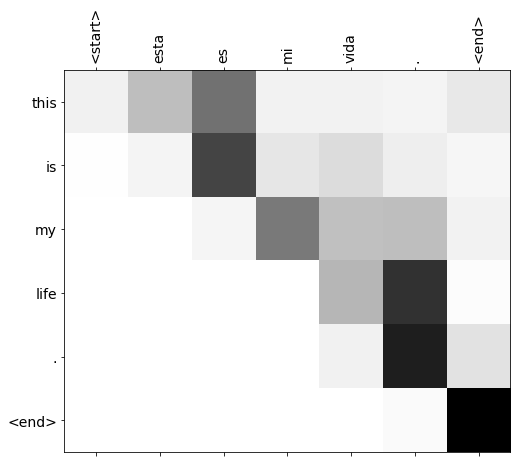

Google Translation : this is my life.


In [ ]:
translate(u'esta es mi vida.')
print("Google Translation : this is my life.")

In [ ]:
#All the variables gets automatically updated when the checkpoint is restored
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

Input : <start> ¿ todavia estan en casa ? <end>
Translation : <start> are you still at home ? <end>


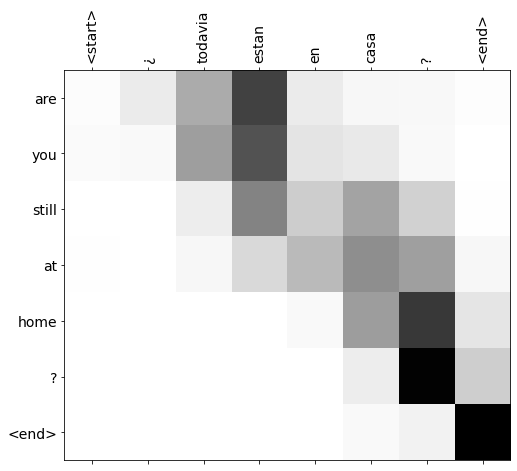

Google Translation : Are they still at home?


In [ ]:
translate(u'¿todavia estan en casa?')
print("Google Translation : Are they still at home?")

Input : <start> ellos bailaran <end>
Translation : <start> they ll dance . <end>


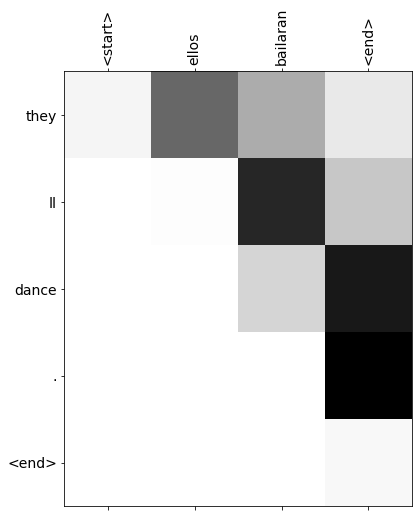

Google Translation : They will dance


In [ ]:
translate(u'Ellos bailarán')
print("Google Translation : They will dance")

Input : <start> trata de averiguarlo . <end>
Translation : <start> try to figure it out . <end>


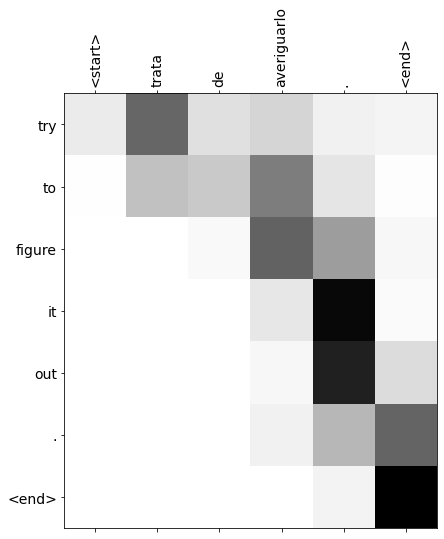

Google Translation : try to find out.


In [ ]:
translate(u'trata de averiguarlo.')
print("Google Translation : try to find out.")